<a href="https://colab.research.google.com/github/Vaneck12/Swimming-eel-like-robot/blob/master/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar geopandas y fiona
!pip install geopandas fiona rasterio
#!/usr/bin/env python

In [ ]:
# make sure to install these packages before running:
!pip install pandas
!pip install sodapy

Index(['the_geom', 'campanya', 'oc', 'nom_oc', 'ajuts', 'codi_pro', 'nom_pro',
       'c_mun_ine', 'n_mun_ine', 'naturalesa', 'data_naix', 'ote',
       'venda_prox', 'eap', 'id_exp', 'ha_dec', 'opfh', 'codi_dop'],
      dtype='object')
0    {'type': 'MultiPolygon', 'coordinates': [[[[2....
1    {'type': 'MultiPolygon', 'coordinates': [[[[0....
2    {'type': 'MultiPolygon', 'coordinates': [[[[1....
3    {'type': 'MultiPolygon', 'coordinates': [[[[1....
4    {'type': 'MultiPolygon', 'coordinates': [[[[0....
Name: the_geom, dtype: object
                                            the_geom campanya  oc  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[2....     2019  28   
1  {'type': 'MultiPolygon', 'coordinates': [[[[0....     2019  33   
2  {'type': 'MultiPolygon', 'coordinates': [[[[1....     2019  03   
3  {'type': 'MultiPolygon', 'coordinates': [[[[1....     2019  25   
4  {'type': 'MultiPolygon', 'coordinates': [[[[0....     2019  37   

            nom_oc                ajuts cod

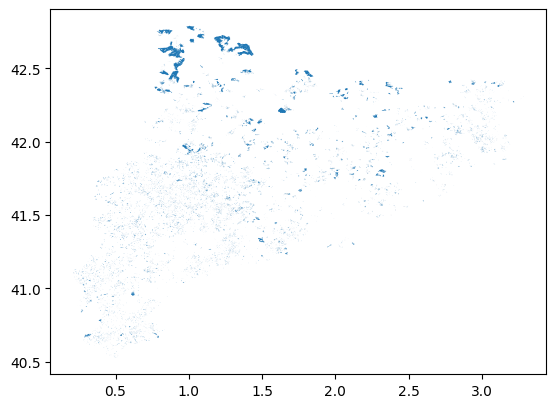

In [42]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
from shapely.geometry import shape, MultiPolygon
import matplotlib.pyplot as plt

# Conectar a la API
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Obtener los primeros 2000 resultados
results = client.get("iqpi-zasj", limit=2000)

# Convertir los resultados en un DataFrame de Pandas
df = pd.DataFrame.from_records(results)

# Mostrar los nombres de las columnas para verificar la columna de geometría
print(df.columns)

# Verificar algunas entradas de la columna de geometría
print(df['the_geom'].head())

# Función para convertir geometría
def safe_shape(geom):
    try:
        return shape(geom) if isinstance(geom, dict) else None
    except Exception as e:
        print(f"Error al convertir la geometría: {e}")
        return None

# Convertir la columna de geometría en objetos de geometría Shapely, manejando errores
df['geometry'] = df['the_geom'].apply(safe_shape)

# Filtrar filas con geometrías válidas
df = df[df['geometry'].notnull()]

# Crear el GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Asignar el CRS adecuado (EPSG:25831 para Cataluña)
#gdf.set_crs(epsg=25831, inplace=True)

# Mostrar el GeoDataFrame
print(gdf.head())

# Visualizar los datos
gdf.plot()
plt.show()


In [ ]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from shapely.geometry import shape

# Verificar el CRS actual del GeoDataFrame
print(f"CRS actual: {gdf.crs}")

# Asignar el CRS inicial como EPSG:4326 si no tiene CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
    print("CRS inicial asignado como EPSG:4326")

# Reproyectar a EPSG:25831 (o EPSG:5166 si es el CRS correcto)
gdf = gdf.to_crs(epsg=25831)  # Cambia a 5166 si es más adecuado
print("Geometrías reproyectadas a EPSG:25831")

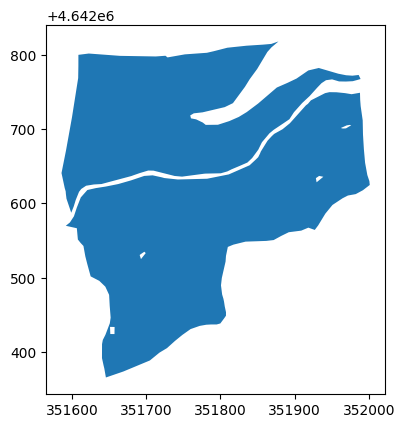

In [60]:
# Seleccionar la parcela en la fila 3 (indexación 0-basada, por lo que es la fila 4)
parcela = gdf.iloc[5]

# Create a GeoDataFrame from the parcela geometry for plotting
gpd.GeoDataFrame(geometry=[parcela['geometry']]).plot()

plt.show()

Bounding box reproyectado: minx=351585.7736999998, miny=4642365.363500001, maxx=352001.1141999997, maxy=4642818.123000001
Ancho del raster: 415, Alto del raster: 452


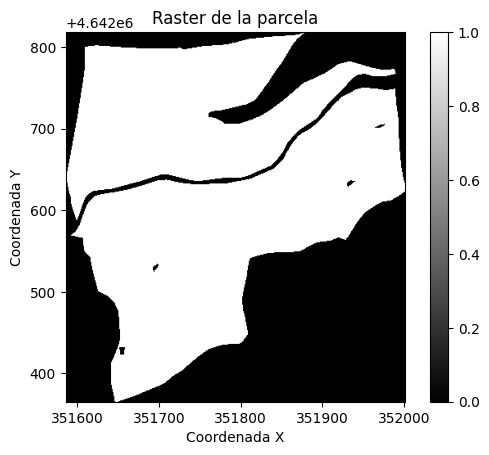

In [61]:
# Seleccionar la parcela en la fila 3 (indexación 0-basada, por lo que es la fila 4)
parcela = gdf.iloc[5]
geom = parcela['geometry']

# Obtener el bounding box de la geometría reproyectada
minx, miny, maxx, maxy = geom.bounds
print(f"Bounding box reproyectado: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")

# 1. Definir el tamaño del píxel (1m x 1m)
pixel_size = 1

# 2. Calcular el ancho y el alto del raster
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
print(f"Ancho del raster: {width}, Alto del raster: {height}")

# Verificar que el ancho y la altura son mayores que 0
if width <= 0 or height <= 0:
    raise ValueError(f"El tamaño del raster es inválido: ancho={width}, alto={height}.")

# 3. Definir la transformada espacial para el raster
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# 4. Crear una matriz vacía para el raster
raster = np.zeros((height, width), dtype=np.uint8)

# 5. Crear una máscara de la geometría de la parcela
mask = geometry_mask([geom], transform=transform, invert=True, out_shape=(height, width))

# 6. Rellenar el raster con la máscara
raster[mask] = 1

# 7. Mostrar el raster
plt.imshow(raster, cmap='gray', extent=(minx, maxx, miny, maxy))
plt.colorbar()
plt.title('Raster de la parcela')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.show()

Parcela Més Petita

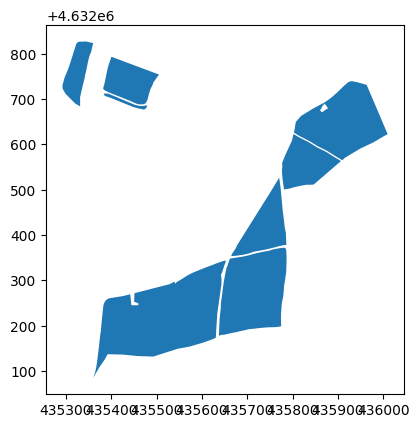

In [58]:
parcela = gdf.iloc[7]

# Create a GeoDataFrame from the parcela geometry for plotting
gpd.GeoDataFrame(geometry=[parcela['geometry']]).plot()

plt.show()

Bounding box reproyectado: minx=435292.0601599999, miny=4632085.681579999, maxx=436009.78882000037, maxy=4632827.036669999
Ancho del raster: 71, Alto del raster: 74


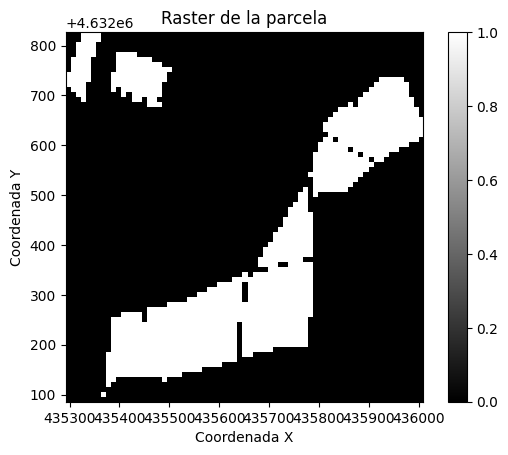

In [64]:
# Seleccionar la parcela en la fila 3 (indexación 0-basada, por lo que es la fila 4)
parcela = gdf.iloc[7]
geom = parcela['geometry']

# Obtener el bounding box de la geometría reproyectada
minx, miny, maxx, maxy = geom.bounds
print(f"Bounding box reproyectado: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")

# 1. Definir el tamaño del píxel (1m x 1m)
pixel_size = 10

# 2. Calcular el ancho y el alto del raster
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
print(f"Ancho del raster: {width}, Alto del raster: {height}")

# Verificar que el ancho y la altura son mayores que 0
if width <= 0 or height <= 0:
    raise ValueError(f"El tamaño del raster es inválido: ancho={width}, alto={height}.")

# 3. Definir la transformada espacial para el raster
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# 4. Crear una matriz vacía para el raster
raster = np.zeros((height, width), dtype=np.uint8)

# 5. Crear una máscara de la geometría de la parcela
mask = geometry_mask([geom], transform=transform, invert=True, out_shape=(height, width))

# 6. Rellenar el raster con la máscara
raster[mask] = 1

# 7. Mostrar el raster
plt.imshow(raster, cmap='gray', extent=(minx, maxx, miny, maxy))
plt.colorbar()
plt.title('Raster de la parcela')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.show()